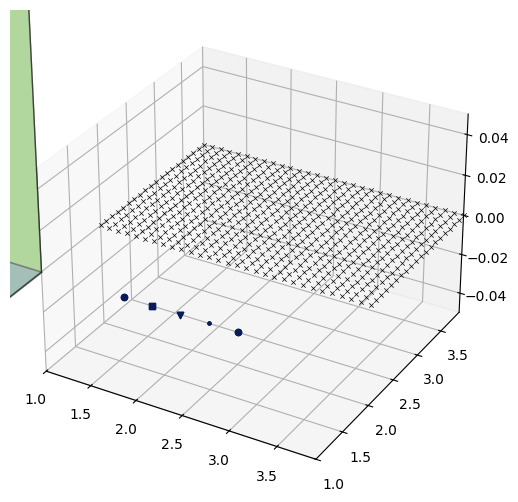

In [ ]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Setup Anechoic Room to neglect room effects and simplify
fs = 16000
room = pra.AnechoicRoom(fs=fs) 

# Speaker Setup: A 5-speaker linear array | Pyroomacoustics uses 3D coordinates, so we set Z=0
num_speakers = 5
speaker_spacing = 0.15
speaker_x = np.linspace(1.9, 3.1, num_speakers)
speaker_locs = np.vstack((speaker_x, np.full(num_speakers, 1.0), np.zeros(num_speakers)))

for loc in speaker_locs.T:
    room.add_source(loc)

# Microphone Grid
spacing = 0.1
x_coords = np.arange(1.0, 4.0, spacing)
y_coords = np.arange(2.0, 4.0, spacing)
X, Y = np.meshgrid(x_coords, y_coords)
mics_locs = np.vstack((X.flatten(), Y.flatten(), np.zeros(X.size)))
mic_array = pra.MicrophoneArray(mics_locs, room.fs)
room.add_microphone_array(mic_array)

# Plotting
room.plot()

In [5]:
# Calculate H for a given frequency
target_freq = 1000.0
c = pra.constants.get('c') # Speed of sound
k = 2 * np.pi * target_freq / c

num_mics = mics_locs.shape[1]
H = np.zeros((num_mics, num_speakers), dtype=complex)

# Populate H
for m in range(num_mics):
    for s in range(num_speakers):
        dist = np.linalg.norm(mics_locs[:, m] - speaker_locs[:, s])
        # Free-field Green's function: (1 / r) * e^(-j * k * r)
        H[m, s] = (1.0 / dist) * np.exp(-1j * k * dist)

# Define Bright and Dark Zones by left/right side of the room
bright_indices = np.where(mics_locs[0, :] < 2.5)[0]
dark_indices = np.where(mics_locs[0, :] >= 2.5)[0]

Hb = H[bright_indices, :]
Hd = H[dark_indices, :]

# The ACC Math 
lambda_reg = 1e-4 # Regularization to limit "array effort"
R_dark = Hd.conj().T @ Hd + lambda_reg * np.eye(num_speakers)
R_bright = Hb.conj().T @ Hb

# Find the eigenvectors, optimal weights are the eigenvector corresponding to the largest eigenvalue
vals, vecs = eig(R_bright, R_dark)
optimal_g = vecs[:, np.argmax(np.real(vals))]

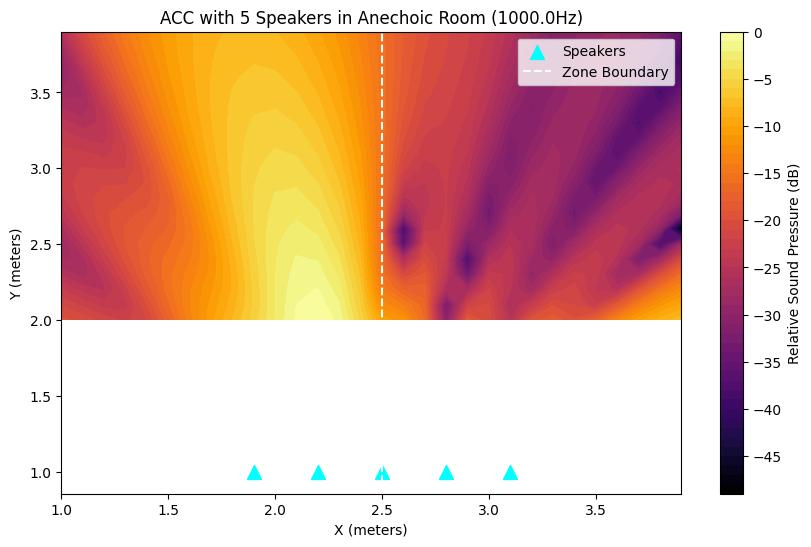

In [6]:
# Multiply the transfer functions by our optimal speaker weights
p = H @ optimal_g
pressure_map = np.abs(p).reshape(X.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, 20 * np.log10(pressure_map / np.max(pressure_map)), levels=50, cmap='inferno')
plt.colorbar(label="Relative Sound Pressure (dB)")

# Overlay speakers and the zone boundary
plt.scatter(speaker_locs[0, :], speaker_locs[1, :], color='cyan', label='Speakers', marker='^', s=100)
plt.axvline(2.5, color='white', linestyle='--', label='Zone Boundary')

plt.title(f"ACC with 5 Speakers in Anechoic Room ({target_freq}Hz)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.show()